In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib qt
%matplotlib widget

In [2]:
import os
import sys
from pathlib import Path

src_dir = str(Path(os.getcwd()).parent / "src")
sys.path.insert(1, src_dir)
#os.environ["PYTHONPATH"] = src_dir

In [3]:
import data_loader
import calculate_concentr_diffs
from concentr_diffs_pathlength import *
from plotting import *
from mbll_functions import *
from utils import *
from mcs_function import *
import config
import pickle
from ray import tune
import matplotlib.pyplot as plt
from inspect import signature
from tqdm.notebook import tqdm
import pandas
import time

load the gray-matter, and blood-vessel pathlengths and scattering counts

In [4]:
gray_matter_mcs_pathlength_data = np.loadtxt(config.pl_dir / "gray_matter_mcs.txt")
blood_vessel_mcs_pathlength_data = np.loadtxt(config.pl_dir / "blood_vessel_pure_mcs.txt")
tumor_mcs_pathlength_data = np.loadtxt(config.pl_dir / "tumor_mcs.txt")

create MCS-Attenuation Object

In [5]:
A_mcs = SimulationAttenuation(config.mcs_func_path)

Loaded data with 50000.0 photons and 30 values for mu_s.


load the m-parameters for the Jacques models

In [6]:
with open(config.m_params_path, "rb") as f:
    jacques_m_params, _, _, _ = pickle.load(f)

In [7]:
jacques_m_params

{'gray matter': array([7.36235175, 0.07880996, 1.82036491]),
 'blood vessel': array([ 26327.23900903, -26318.31894318,  28718.23874622]),
 'tumor': array([6.69629536, 0.73994694, 4.47359248]),
 'general': array([8.17504229, 0.01010447, 1.44170499])}

# Forward Test

- Input tissue concentrations, and reconstruct spectra with every model
- compute squared average (over wavelength range) attenuation error per tissue and model

In [8]:
with open(config.simulated_dataset_dir / "simulation_data.pickle", "rb") as f:
    wavelengths, simulation_data = pickle.load(f)

In [9]:
tissue_types_long = list(simulation_data.keys())

In [10]:
mu_a_matrix = data_loader.DataLoader.absorption_coefs(
    wavelengths,
    use_diff_oxycco=False,
    use_water_and_fat=True
)

In [11]:
baseline_data = {}

Interpolate path and scatter lengths for MBLL + MCS

In [12]:
lengths = tuple()
for mcs_data in (gray_matter_mcs_pathlength_data, tumor_mcs_pathlength_data, blood_vessel_mcs_pathlength_data):
    pathlength = np.interp(wavelengths, mcs_data[:, 0], mcs_data[:, 4] / 10) # convert to cm
    # notice the minus: mean scatterlength = mean pathlength - ((mean scattercount)/mu_s)
    scatterlength = mcs_data[:, 4] / 10 - mcs_data[:, 5] / (mcs_data[:, 2] * 10)
    scatterlength = np.interp(wavelengths, mcs_data[:, 0], scatterlength)
    lengths += (pathlength, scatterlength)

gray_matter_pathlength, gray_matter_scatterlength, tumor_pathlength, tumor_scatterlength, blood_vessel_pathlength, blood_vessel_scatterlength = lengths

In [13]:
#gray_matter_baseline_attenuation = np.interp(
#    wavelengths,
#    gray_matter_mcs_pathlength_data[:, 0],
#    -np.log(gray_matter_mcs_pathlength_data[:, 3])
#)

# take baseline attenuation from simulation data
# this avoids small error due to interpolation
# this small interpolation error causes large errors in concentration reconstruction for MBLL
# Otherwise, when reconstructing concentr. for baseline attenuation, we will not get baseline concentrations

gray_matter_baseline_attenuation = simulation_data["gray matter"][-1][:, 0]

# for blood vessel average, there is no simulation data
blood_vessel_baseline_attenuation = np.interp(
    wavelengths,
    blood_vessel_mcs_pathlength_data[:, 0],
    -np.log(blood_vessel_mcs_pathlength_data[:, 3])
)

tumor_baseline_attenuation = simulation_data["tumor"][-1][:, 0]

In [14]:
baseline_data["attenuation_mcs"] = [gray_matter_baseline_attenuation, blood_vessel_baseline_attenuation, tumor_baseline_attenuation]
baseline_data["pathlength_mcs"] = [gray_matter_pathlength, blood_vessel_pathlength, tumor_pathlength]
baseline_data["scatterlength_mcs"] = [gray_matter_scatterlength, blood_vessel_scatterlength, tumor_scatterlength]

In [15]:
# diffusion + MBLL
# compute baseline attenuation, pathlength and scatterlength
baseline_attenuations_diffusion, baseline_pathlengths_diffusion, baseline_scatterlengths_diffusion = [], [], []
baseline_attenuations_jacques, baseline_pathlengths_jacques, baseline_scatterlengths_jacques = [], [], []
baseline_pathlengths_jacques2 = []
for tissue_type in ["gray matter", "blood vessel", "tumor"]:
    params = (
        wavelengths,
        mu_a_matrix,
        data_loader.DataLoader.tissue_parameters[tissue_type][0],
        *data_loader.DataLoader.tissue_parameters[tissue_type][1],
        *data_loader.DataLoader.tissue_parameters[tissue_type][-2:],
    )
    params_jacques = params[:-2]
    params_jacques += tuple(jacques_m_params[tissue_type])
    params_jacques += (data_loader.DataLoader.tissue_parameters[tissue_type][-2],)
    baseline_attenuations_diffusion.append(A_carp_concentrations(*params)[:, 0])
    baseline_pathlengths_diffusion.append(A_carp_pathlength(*params)[:, 0]),
    baseline_scatterlengths_diffusion.append(A_carp_scatterlength(*params)[:, 0])
    baseline_attenuations_jacques.append(A_jacques_concentrations(*params_jacques[:-1])[:, 0])
    baseline_pathlengths_jacques.append(A_jacques_pathlength(*params_jacques[:-1])[:, 0]),
    baseline_scatterlengths_jacques.append(A_jacques_scatterlength(*params_jacques)[:, 0])
    baseline_pathlengths_jacques2.append(A_jacques_pathlength_2(*params_jacques[:-1])[:, 0])

In [16]:
baseline_data["attenuation_diffusion"] = baseline_attenuations_diffusion
baseline_data["pathlength_diffusion"] = baseline_pathlengths_diffusion
baseline_data["scatterlength_diffusion"] = baseline_scatterlengths_diffusion
baseline_data["attenuation_jacques"] = baseline_attenuations_jacques
baseline_data["pathlength_jacques"] = baseline_pathlengths_jacques
baseline_data["scatterlength_jacques"] = baseline_scatterlengths_jacques

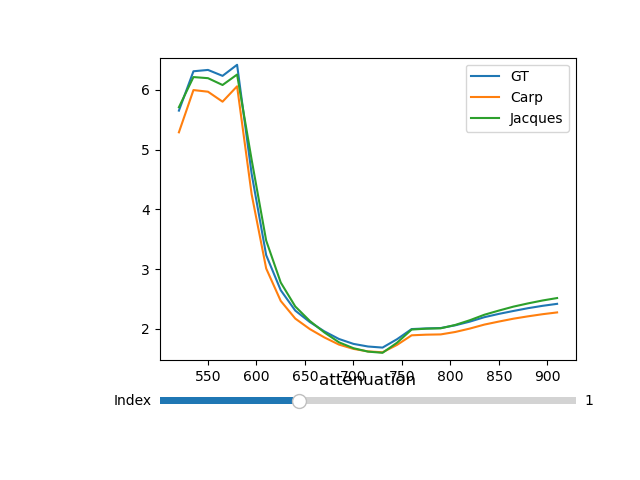

In [17]:
plot_spectra_slider(np.array([[gray_matter_baseline_attenuation, blood_vessel_baseline_attenuation, tumor_baseline_attenuation], baseline_attenuations_diffusion, baseline_attenuations_jacques]).transpose(0, 2, 1), wavelengths, ["GT", "Carp", "Jacques"], title="attenuation")

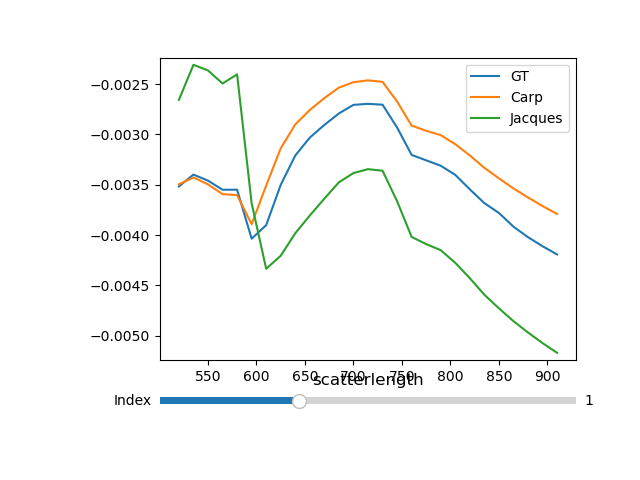

In [18]:
plot_spectra_slider(np.array([[gray_matter_scatterlength, blood_vessel_scatterlength, tumor_scatterlength], baseline_scatterlengths_diffusion, baseline_scatterlengths_jacques]).transpose(0, 2, 1), wavelengths, ["GT", "Carp", "Jacques"], title="scatterlength")

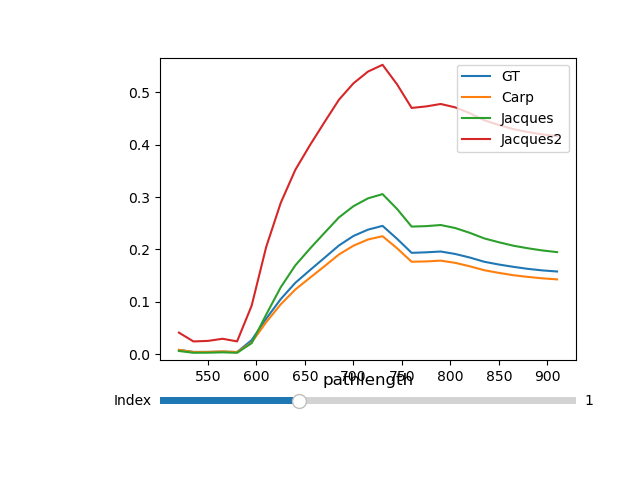

In [19]:
plot_spectra_slider(np.array([[gray_matter_pathlength, blood_vessel_pathlength, tumor_pathlength], baseline_pathlengths_diffusion, baseline_pathlengths_jacques, baseline_pathlengths_jacques2]).transpose(0, 2, 1), wavelengths, ["GT", "Carp", "Jacques", "Jacques2"], title="pathlength")

With absorption-dependence:

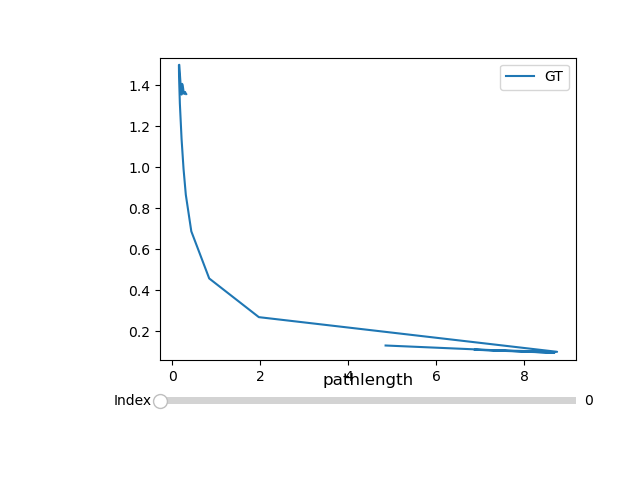

In [23]:
absorption_per_wavelength = data_loader.DataLoader.mu_a_func_gray_matter(wavelengths)
plot_spectra_slider(np.array([[gray_matter_pathlength]]).transpose(0, 2, 1), absorption_per_wavelength, ["GT"], title="pathlength")

Save plot for MCS, Jacques, Diffusion PL/SL comparison

In [ ]:
pl_comparison_data = dict()
sl_comparison_data = dict()

for tissue_idx, tissue in enumerate(["gray matter", "blood vessel", "tumor"]):
    pl_comparison_data[tissue] = np.empty((len(wavelengths), 4))
    sl_comparison_data[tissue] = np.empty((len(wavelengths), 4))
    for model_idx, model_str in enumerate(["mcs", "diffusion", "jacques"], start=1):
        pl_comparison_data[tissue][:, 0] = wavelengths
        sl_comparison_data[tissue][:, 0] = wavelengths
        pl_comparison_data[tissue][:, model_idx] = baseline_data[f"pathlength_{model_str}"][tissue_idx]
        sl_comparison_data[tissue][:, model_idx] = baseline_data[f"scatterlength_{model_str}"][tissue_idx]
    
    np.savetxt(
        config.eval_dir / f"simulated/forward/pl_comp_{tissue}.dat",
        pl_comparison_data[tissue],
        comments="",
        delimiter="\t",
        header="wavelengths\tmcs\tdiffusion\tjacques"
    )

    np.savetxt(
        config.eval_dir / f"simulated/forward/sl_comp_{tissue}.dat",
        sl_comparison_data[tissue],
        comments="",
        delimiter="\t",
        header="wavelengths\tmcs\tdiffusion\tjacques"
    )

all models and their tissue-specific inputs

In [ ]:
params_model_dict = {}
for model_suffix in ["mcs", "jacques", "diffusion"]:
    params_tissue_dict = {}
    for tissue in ["gray matter", "artery", "vein", "tumor"]:
        if tissue == "vein":
            baseline_index = 1
        else:
            baseline_idx = ["gray matter", "artery", "tumor"].index(tissue)

        params_tissue_dict[tissue] = {
            "baseline_attenuation": baseline_data["attenuation_" + model_suffix][baseline_idx],
            "pathlength": baseline_data["pathlength_" + model_suffix][baseline_idx],
            "scatterlength": baseline_data["scatterlength_" + model_suffix][baseline_idx],
            "baseline_a": data_loader.DataLoader.tissue_parameters[tissue][1][0],
            "baseline_b": data_loader.DataLoader.tissue_parameters[tissue][1][1],
            "baseline_c": data_loader.DataLoader.tissue_parameters[tissue][0],
            "g": data_loader.DataLoader.tissue_parameters[tissue][2],
        }
    params_model_dict[model_suffix] = params_tissue_dict


In [ ]:
gray_matter_params_constant_pl = params_model_dict["mcs"]["gray matter"].copy()
gray_matter_params_constant_pl.update(
    pathlength=np.ones(len(wavelengths)),
    scatterlength=np.zeros(len(wavelengths))
)
blood_vessel_params_constant_pl = params_model_dict["mcs"]["artery"].copy()
blood_vessel_params_constant_pl.update(
    pathlength=np.ones(len(wavelengths)),
    scatterlength=np.zeros(len(wavelengths))
)
tumor_params_constant_pl = params_model_dict["mcs"]["tumor"].copy()
tumor_params_constant_pl.update(
    pathlength=np.ones(len(wavelengths)),
    scatterlength=np.zeros(len(wavelengths))
)

forward_models = {
    "MBLL MCS": (
        mbll_new,
        params_model_dict["mcs"]
    ),
    "MBLL Carp": (
        mbll_new,
        params_model_dict["diffusion"]
        
    ),
    "MBLL const": (
        # mbll but with constant path- and scatterlengths
        mbll_new, 
        {
            "gray matter": gray_matter_params_constant_pl,
            "artery": blood_vessel_params_constant_pl,
            "vein": blood_vessel_params_constant_pl,
            "tumor": tumor_params_constant_pl
        }
    ),
    "MBLL const GM": (
        # mbll but with constant path- and scatterlengths from gray matter
        mbll_new, 
        {
            "gray matter": params_model_dict["mcs"]["gray matter"],
            "artery": params_model_dict["mcs"]["gray matter"],
            "vein": params_model_dict["mcs"]["gray matter"],
            "tumor": params_model_dict["mcs"]["gray matter"]
        }
    ),
    "Jacques, tissue specific": (
        # Jacques with tissue-specific m-parameters
        A_jacques_concentrations,
        {tissue : {f"m{i}" : jacques_m_params[(tissue if tissue not in {"artery", "vein"} else "blood vessel")][i-1] for i in range(1, 4)} for tissue in tissue_types_long},
    ),
    "Jacques, general": (# Jacques with general m-parameters
        A_jacques_concentrations,
        {tissue_type : {f"m{i}" : jacques_m_params["general"][i-1] for i in range(1, 4)} for tissue_type in tissue_types_long},          
    ),
    "Carp": (
        A_carp_concentrations,
        {tissue_type : {("g", "n")[i-2] : data_loader.DataLoader.tissue_parameters[tissue_type][i] for i in range(2, 4)} for tissue_type in tissue_types_long},
    ),
    "MCS NLLS": (
        A_mcs.A_concentrations,
        {tissue_type: dict() for tissue_type in tissue_types_long},
    ),
    #"Patterson": (
    #    A_patterson_concentrations,
    #    {tissue_type : {"n" : data_loader.DataLoader.tissue_parameters[tissue_type][-1]} for tissue_type in tissue_types_long}
    #)
}

forward_times = np.zeros((len(forward_models)))


In [ ]:
#(model, tissue-type, num_spectra, wavelengths)
reconstructed_spectra = np.empty((len(forward_models), len(simulation_data.keys()), simulation_data["gray matter"][-1].shape[1], len(wavelengths)))

In [ ]:
for model_idx, model_str in enumerate(forward_models.keys()):
    for tissue_idx, tissue_type in enumerate(tissue_types_long):
        for spectrum_idx, params in enumerate(np.row_stack(simulation_data[tissue_type][:2]).T):
            forward_times[model_idx] = -time.perf_counter()
            A_reconstructed = forward_models[model_str][0](
                wavelengths,
                mu_a_matrix,
                params[:-2],
                *params[-2:],
                **forward_models[model_str][1][tissue_type]
            )
            forward_times[model_idx] += time.perf_counter()
            reconstructed_spectra[model_idx, tissue_idx, spectrum_idx, :] = A_reconstructed[:, 0]

forward_times /= len(tissue_types_long) * simulation_data["artery"][-1].shape[1]

In [ ]:
print(forward_models.keys())

In [ ]:
df = pandas.DataFrame(forward_times[:, None])
df.index = ["MBLL+MC", "MBLL+$\delta$-P1", r"MBLL, $\bar{L}_p=1$", r"MBLL, gray matter $\bar{L}_p$", "Jacques, specific", "Jacques, general", "$\delta$-P1", "Inverse MC"]
df.columns = ["Runtime per spectrum (s)"]
print(df)

Plot reconstructed spectra

In [ ]:
plotted_tissue="vein"

In [ ]:
# models, tissue, spectra, wavelengths
reconstructed_spectra_copy = reconstructed_spectra.copy()
model_mask = np.array([True] * len(list(forward_models.keys())))
model_mask[[2, 3]] = False # don't plot MBLL const and MBLL const GM PL
tissue_idx = tissue_types_long.index(plotted_tissue)
forward_plot_data_mpl = np.concatenate(
    (
        #(models, spectra, wavelengths)
        simulation_data[plotted_tissue][-1].T[None, ...],
        reconstructed_spectra[model_mask, tissue_idx, :, :]
    ),
    axis=0
)

# (molecules,wavelenghts,spectra)
plot_spectra_slider(
    forward_plot_data_mpl.transpose(0, 2, 1),
    wavelengths,
    ["MCS GT"] + list(np.array(list(forward_models.keys()))[model_mask]),
    #["MCS GT", "jt", "jg", "mcs", "c", "p"],
    title=plotted_tissue
)

Store the results.

In [ ]:
with open(config.eval_dir / "simulated/forward/results.pickle", "wb+") as f:
    pickle.dump((reconstructed_spectra, forward_times), f)

Create text files for report.

In [ ]:
forward_spectrum_idx = 1 # highly perturbed

In [ ]:
model_identifiers = [
    "ground_truth", "mbll_mcs", "mbll_diffusion", "mbll_const", "mbll_const_gm", "jacques_specific", "jacques_general", "diffusion", "inverse_mcs",
]
for tissue_idx, tissue in enumerate(tissue_types_long):
    forward_plot_data_tex = np.empty((simulation_data[tissue][-1].shape[0], len(forward_models)+2))
    forward_plot_data_tex[:, 0] = wavelengths
    forward_plot_data_tex[:, 1] = simulation_data[tissue][-1][:, forward_spectrum_idx]
    forward_plot_data_tex[:, 2:] = reconstructed_spectra[:, tissue_idx, forward_spectrum_idx, :].T
    np.savetxt(
        config.eval_dir / f"simulated/forward/{tissue}.dat",
        forward_plot_data_tex,
        header="\t".join(["wavelengths"] + model_identifiers),
        comments="",
        delimiter="\t",
    )

Compute squared attenuation error

In [ ]:
# models, tissue, spectrum
squared_attenuation_error = np.empty((len(forward_models), 4, simulation_data["tumor"][-1].shape[1]))
# models, tissue + 1
squared_attenuation_error_total_avg = np.empty((len(forward_models), 5))

num_wavelengths = simulation_data["tumor"][-1].shape[0]

for tissue_idx, tissue in enumerate(tissue_types_long):
    prediction_means = np.average(simulation_data[tissue][-1], axis=0)[None, :]
    squared_attenuation_error[:, tissue_idx, :] = np.sqrt(np.sum((reconstructed_spectra[:, tissue_idx, :, :] - simulation_data[tissue][-1][:, :, None].T)**2, axis=-1)/num_wavelengths)/prediction_means
    squared_attenuation_error_total_avg[:, tissue_idx] = np.average(squared_attenuation_error[:, tissue_idx, :], axis=-1)

squared_attenuation_error_total_avg[:, 4] = np.average(squared_attenuation_error_total_avg[:, :4], axis=-1)

In [ ]:
df = pandas.DataFrame(squared_attenuation_error_total_avg)
df.index = ["MBLL+MC", "MBLL+$\delta$-P1", r"MBLL, $\bar{L}_p=1$", r"MBLL, gray matter $\bar{L}_p$", "Jacques, specific", "Jacques, general", "$\delta$-P1", "Inverse MC"]
df.columns = list(map(str.capitalize, ["gray matter", "artery", "vein", "tumor", "average"]))
print(df)

In [ ]:
df.to_csv(
    config.eval_dir/"simulated/forward/squared_attenuation_error_table.txt",
    sep="\t",
    index_label="Models"
)

# Backward Test

## Simulated Spectra

In [ ]:
# (models, tissues, params)
num_params = simulation_data["gray matter"][0].shape[0] + simulation_data["gray matter"][1].shape[0]

In [ ]:
# object for MBLL + MCS
A_mbll_fit_simulated_mcs = A_mbll_fit(
    wavelengths,
    mu_a_matrix,
    ["gray matter", "blood vessel", "tumor"],
    [gray_matter_pathlength, blood_vessel_pathlength, tumor_pathlength],
    [gray_matter_scatterlength, blood_vessel_scatterlength, tumor_scatterlength],
    [gray_matter_baseline_attenuation, blood_vessel_baseline_attenuation, tumor_baseline_attenuation],
    [data_loader.DataLoader.tissue_parameters[tissue][0] for tissue in ["gray matter", "blood vessel", "tumor"]],
    *np.array(([data_loader.DataLoader.tissue_parameters[tissue][1] for tissue in ["gray matter", "blood vessel", "tumor"]])).T,
    [data_loader.DataLoader.tissue_parameters[tissue][2] for tissue in ["gray matter", "blood vessel", "tumor"]]
)


In [ ]:
A_mbll_fit_simulated_diffusion = A_mbll_fit(
    wavelengths,
    mu_a_matrix,
    ["gray matter", "blood vessel", "tumor"],
    baseline_pathlengths_diffusion,
    baseline_scatterlengths_diffusion,
    baseline_attenuations_diffusion,
    [data_loader.DataLoader.tissue_parameters[tissue][0] for tissue in ["gray matter", "blood vessel", "tumor"]],
    *(np.array(([data_loader.DataLoader.tissue_parameters[tissue][1] for tissue in ["gray matter", "blood vessel", "tumor"]])).T),
    [data_loader.DataLoader.tissue_parameters[tissue][2] for tissue in ["gray matter", "blood vessel", "tumor"]]
)


In [ ]:
A_mbll_fit_simulated_constant_pl = A_mbll_fit(
    wavelengths,
    mu_a_matrix,
    ["gray matter", "blood vessel", "tumor"],
    np.ones((3, len(wavelengths))),
    np.zeros((3, len(wavelengths))),
    [gray_matter_baseline_attenuation, blood_vessel_baseline_attenuation, tumor_baseline_attenuation],
    [data_loader.DataLoader.tissue_parameters[tissue][0] for tissue in ["gray matter", "blood vessel", "tumor"]],
    *(np.array(([data_loader.DataLoader.tissue_parameters[tissue][1] for tissue in ["gray matter", "blood vessel", "tumor"]])).T),
    [data_loader.DataLoader.tissue_parameters[tissue][2] for tissue in ["gray matter", "blood vessel", "tumor"]]
)

In [ ]:
A_mbll_fit_simulated_constant_gm_pl = A_mbll_fit(
    wavelengths,
    mu_a_matrix,
    ["gray matter", "blood vessel", "tumor"],
    [gray_matter_pathlength, gray_matter_pathlength, gray_matter_pathlength],
    [gray_matter_scatterlength, gray_matter_scatterlength, gray_matter_scatterlength],
    [gray_matter_baseline_attenuation, gray_matter_baseline_attenuation, gray_matter_baseline_attenuation],
    [data_loader.DataLoader.tissue_parameters["gray matter"][0]]*3,
    *np.array(([data_loader.DataLoader.tissue_parameters["gray matter"][1]]*3)).T,
    [data_loader.DataLoader.tissue_parameters["gray matter"][2]]*3
)


In [ ]:
mbll_tissue_map = {
    "gray matter" : "gray matter",
    "vein": "blood vessel",
    "artery": "blood vessel",
    "tumor": "tumor"
}

tissue_types_long = list(mbll_tissue_map.keys())

backward_models_mbll = [
    A_mbll_fit_simulated_mcs,
    A_mbll_fit_simulated_diffusion,
    A_mbll_fit_simulated_constant_pl,
    A_mbll_fit_simulated_constant_gm_pl
]

mcs_sparsity=4
# NOTE: make sure to provide blood-fraction-models
backward_models_nonlinear = {
    # Jacques with tissue-specific m-parameters
    "Jacques tissue specific":
    (A_jacques_blood_fraction, {tissue : {f"const_vals" : list(jacques_m_params[tissue if tissue not in {"artery", "vein"} else "blood vessel"])} for tissue in tissue_types_long}),
    # Jacques with general m-parameters
    "Jacques general":
    (A_jacques_blood_fraction, {tissue : {f"const_vals" : list(jacques_m_params["general"])} for tissue in tissue_types_long}),
     "Carp":
    (A_carp_blood_fraction, {tissue: {"const_vals" : data_loader.DataLoader.tissue_parameters[tissue][-2:]} for tissue in tissue_types_long}),
    "NLLS+MCS":
    (A_mcs.A_blood_fraction, {tissue : {"jacobian" : A_mcs.jacobian_blood_fraction} for tissue in tissue_types_long}),
    "NLLS+MCS, sparse":
    (A_mcs.A_blood_fraction, {tissue : {"jacobian" : A_mcs.jacobian_blood_fraction} for tissue in tissue_types_long}),
}

In [ ]:
#(tissue, models, params, spectra)
reconstructed_concentrations = np.empty(( 
    len(simulation_data.keys()),
    len(backward_models_mbll) + len(backward_models_nonlinear),
    6,
    simulation_data["gray matter"][-1].shape[1]
))

#(tissue, model, 2, spectra)
reconstructed_scattering_params = np.empty((
    len(simulation_data.keys()),
    len(backward_models_mbll) + len(backward_models_nonlinear),
    2,
    simulation_data["gray matter"][-1].shape[1]
)
)

Fit for MBLL models

In [ ]:

for model_idx, model in enumerate(backward_models_mbll):
    for tissue_idx, tissue_type in enumerate(tissue_types_long):
        for spectrum_idx, spectrum in enumerate(simulation_data[tissue_type][-1].T):
            res = model.concentr_fit(
                A=spectrum,
                tissue_type=mbll_tissue_map[tissue_type]
            )

            reconstructed_concentrations[tissue_idx, model_idx, :, spectrum_idx] = res[:6] # omit a parameter, b is not computed anyways
            reconstructed_scattering_params[tissue_idx, model_idx, 0, spectrum_idx] = res[-1] # copy a parameter
            reconstructed_scattering_params[tissue_idx, model_idx, 1, spectrum_idx] = np.nan # b is not computed

Nonlinear models

In [ ]:
for model_idx, model_str in tqdm(list(enumerate(backward_models_nonlinear.keys(), start=len(backward_models_mbll)))):
    model_func = backward_models_nonlinear[model_str][0]
    print(f"Reconstruction for {model_str}")
    for tissue_idx, tissue_type in enumerate(tissue_types_long):
        for spectrum_idx, spectrum in enumerate(simulation_data[tissue_type][-1].T):
            spectrum_tmp, wavelengths_tmp, mu_a_matrix_tmp = spectrum, wavelengths, mu_a_matrix
            if "sparse" in model_str:
                wavelengths_tmp, spectrum_tmp, mu_a_matrix_tmp = wavelengths[::mcs_sparsity], spectrum[::mcs_sparsity], mu_a_matrix[::mcs_sparsity, :]
            res, errors = concentr_fit_nonlinear_single_tissue(
                spectrum_tmp,
                wavelengths_tmp,
                mu_a_matrix_tmp,
                model_func,
                variables_bool_arr=([True] * num_params) + ([False] * (len(signature(model_func).parameters) - 5)),
                left_bounds = np.array([0] * num_params),
                right_bounds=np.array([1, 1, 0.05, 0.05, 1, 1, 100, 7]),
                update_init=False,
                constraint=None,
                init_vals=concentrations_to_blood_fraction(np.row_stack(simulation_data[tissue_type][:2])[:, 0]),
                **backward_models_nonlinear[model_str][1][tissue_type]
            )
            
            reconstructed_concentrations[tissue_idx, model_idx, :, spectrum_idx] = blood_fraction_to_concentrations(res[:6, 0])
            reconstructed_scattering_params[tissue_idx, model_idx, :, spectrum_idx] = res[-2:, 0]
        

In [ ]:
with open(config.eval_dir/"simulated/backward/reconstructed_concentrations.pickle", "wb") as f:
    pickle.dump(reconstructed_concentrations, f)

In [ ]:
plotted_spectrum_idx = 1

In [ ]:
# append GT concentrations, cut scattering params
# (tissue, models, concentrations)
plot_data = np.concatenate(
    (
        np.array([simulation_data[tissue][0][:, plotted_spectrum_idx] for tissue in tissue_types_long])[:, None, :],
        reconstructed_concentrations[:, :, :6, plotted_spectrum_idx]
    ),
axis=1)

#plot_data[:, :, -2:] /= 10
#plot_data[:, 3, :] = 0

plot_concentrations_bar(
    plot_data, 
    tissue_types_long,
    ["GT", "MBLL MCS", "MBLL Carp", "MBLL const", "MBLL const GM", "Jacques specific", "Jaques general", "Carp", "NLLS+MCS", "NLLS+MCS sparse"],
    ["Hb02", "Hbb", "oxCCO", "redCCO", "Water", "Fat"]
)

Save data for plotting.

In [ ]:
with open(config.eval_dir/"simulated/backward/bar_plot_data.pickle", "wb") as f:
    pickle.dump(plot_data, f)

with open(config.eval_dir/"simulated/backward/model_indices.txt", "w") as f:
    f.writelines(
        [
            f"{i}: {model_str}\n" for (i, model_str) in enumerate(
                [
                 "GT", "MBLL+MCS", "MBLL+Carp", "MBLL+const PL", "MBLL const GM", "Jacques, specific",
                 "Jacques, general", "Carp", "MCS+NLLS", "MCS+NLLS,sparse"
                ]
            )
        ]
    )

In [ ]:
# models, tissue, spectrum
squared_concentration_error = np.empty((len(backward_models_mbll) + len(backward_models_nonlinear), 4, simulation_data["tumor"][-1].shape[1]))
# models, tissue + 1
squared_concentration_error_total_avg = np.empty((len(backward_models_mbll) + len(backward_models_nonlinear), 5))

# t, m, p, s for reconstructed_concentrations
for tissue_idx, tissue in enumerate(tissue_types_long):
    concentration_means = np.average(simulation_data[tissue][1], axis=0)
    squared_concentration_error[:, tissue_idx, :] = np.sqrt(np.sum((reconstructed_concentrations[tissue_idx, :, :, :] - simulation_data[tissue][0][None, :, :])**2, axis=1)/6)/concentration_means
    squared_concentration_error_total_avg[:, tissue_idx] = np.average(squared_concentration_error[:, tissue_idx, :], axis=-1)

squared_concentration_error_total_avg[:, 4] = np.average(squared_concentration_error_total_avg[:, :4], axis=-1)

In [ ]:
list(backward_models_nonlinear.keys())

In [ ]:
df = pandas.DataFrame(squared_concentration_error_total_avg)
df.index = ["MBLL+MC", "MBLL+$\delta$-P1", r"MBLL, $\bar{L}_p=1$", r"MBLL, gray matter $\bar{L}_p$", "Jacques, specific", "Jacques, general", "$\delta$-P1", "Inverse MC", "Inverse MC, sparse"]
#df.index = ["MBLL MCS", "MBLL Carp", "MBLL const.", "MBLL const GM"] + list(backward_models_nonlinear.keys())
df.columns = list(map(str.capitalize, ["gray matter", "artery", "vein", "tumor", "average"]))
print(df)

In [ ]:
df.to_csv(
    config.eval_dir/"simulated/backward/squared_concentration_error_table.txt",
    sep="\t",
    index_label="Models"
)

In [ ]:
num_models = len(backward_models_mbll) + len(backward_models_nonlinear)
scatter_table_data = np.empty((num_models + 1, 8)) #8 = 2 (a,b) * 4 (tissues)
for tissue_idx, tissue in enumerate(tissue_types_long):
    scatter_table_data[0, tissue_idx*2] = simulation_data[tissue][1][0, 1]
    scatter_table_data[0, tissue_idx*2 + 1] = simulation_data[tissue][1][1, 1]
    scatter_table_data[1:, (tissue_idx*2):(tissue_idx*2+2)] = reconstructed_scattering_params[tissue_idx, :, :, 1]

df = pandas.DataFrame(scatter_table_data)
df.index = ["GT", "MBLL MCS", "MBLL Carp", "MBLL const.", "MBLL const GM"] + list(backward_models_nonlinear.keys())
df.index = ["MC simulation", "MBLL+MC", "MBLL+$\delta$-P1", r"MBLL, $\bar{L}_p$=1", r"MBLL, gray matter $\bar{L}_p$", "Jacques, specific", "Jacques, general", "$\delta$-P1", "Inverse MC", "Inverse MC, sparse"]
df.columns = ["a, cortex [cm$^{-1}$]", "b, cortex", "a, artery [cm$^{-1}$]", "b, artery ", "a, vein [cm$^{-1}$]", "b, vein", "a, tumor [cm$^{-1}$]", "b, tumor"]
print(df)

In [ ]:
df.to_csv(
    config.eval_dir/"simulated/backward/scatter_values.txt",
    sep="\t",
    index_label="Models"
)